<a href="https://colab.research.google.com/github/mlej8/ECSE552/blob/main/ECSE552_T7_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECSE - Tutorial 7
## Using Recurrent Neural Networks for Headline Generation

2021 March 10 & 11

We'll be covering how to use Long short-term memory (LSTM) units to create a Sequence-to-Sequence ([Seq2Seq](https://arxiv.org/abs/1409.3215)) model to solve the task of headline generation.

Specifically, the task involves generating headlines from article texts. We are doing so using Recurrent Neural Networks. 

<img src="https://dl.sphericalcow.xyz/ecse552/T7/task_overview.jpg" width="500">

In [ ]:
from torch import nn
from torch.utils.data import random_split, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch
import pandas as pd
import json
import pickle
from torch.optim import Adam
import torch.nn.functional as F
from tabulate import tabulate
from IPython.display import HTML, display

In [ ]:
!pip install pytorch_lightning
!pip install pytorch-ranger
from pytorch_ranger import RangerQH 
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

## The Dataset

The dataset for this headline generation task are headlines are derived from pages scraped from CNN.com between approximately 2009 and 2016. The raw data is [available here](https://cs.nyu.edu/~kcho/DMQA/). 

I've extracted headlines and articles from the pages, along with other metadata. We will be only using the title and the body text of each article. The text was also tokenised, with tokens with occurence less than 3 omitted. Tokenization is done by first normalizing the text, then adding a starting and ending token. The ^ character is the starting token means start of the sentence and $ means end of a sentence. Each word is then separated by a tokenizer, each one of those tokens will be assigned a number. It's important to note that these tokens will be maintained for all the texts in this datase. So the same token will always have the same id. For example, the word official will always be token number 2. 

In [ ]:
!curl -O https://dl.sphericalcow.xyz/ecse552/T7/articles_norm.csv.gz
!curl -O https://dl.sphericalcow.xyz/ecse552/T7/news_dataset.py
!curl -O https://dl.sphericalcow.xyz/ecse552/T4/dict_logger.py
from dict_logger import DictLogger
from news_dataset import NewsDataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  172M  100  172M    0     0  10.5M      0  0:00:16  0:00:16 --:--:-- 11.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2488  100  2488    0     0   6930      0 --:--:-- --:--:-- --:--:--  6930
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1635  100  1635    0     0   7108      0 --:--:-- --:--:-- --:--:--  7077


In [ ]:
df = pd.read_csv('articles_norm.csv.gz').set_index('Unnamed: 0')
df.head(4)

,file,section,title,author,pubdate,description,body_text,body_norm,title_norm,description_norm,body_tokens,title_tokens,description_tokens,description_idxs,title_idxs,body_idxs
Unnamed: 0,,,,,,,,,,,,,,,,
0,0001d1afc246a7964130f43ae940af6bc6c57f01.html,middleeast,"Strike against Syria? Obama backs it, but want...","By Catherine E. Shoichet and Tom Watkins, CNN",2013-08-31T07:13:37Z,"President Obama said the U.S.""should take mili...",It's official: U.S. President Barack Obama wan...,^ it's official us president barack obama want...,^ strike against syria obama backs it but want...,^ president obama said the usshould take milit...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 110, 37, 18, 7, 111, 1, 108, 8, 52, 10, 11...","[0, 5, 7, 101, 22, 43, 16, 36, 37, 38, 39, 44,...","[0, 40, 17, 19, 6, 20, 10, 5, 6, 15, 21, 40, 1...","[0, 40, 20, 21, 19, 10, 12, 6, 40, 2, 8, 2, 10...","[0, 40, 10, 21, 38, 20, 40, 16, 7, 7, 10, 4, 1..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef.html,sport,Bolt completes golden hat-trick as Jamaica rom...,NaN,2013-08-18T15:07:43Z,Usain Bolt rounded off the world championships...,(CNN) -- Usain Bolt rounded off the world cham...,^ usain bolt rounded off the world championshi...,^ bolt completes golden hattrick as jamaica ro...,^ usain bolt rounded off the world championshi...,"[0, 117, 118, 119, 120, 22, 121, 122, 123, 124...","[0, 118, 200, 201, 202, 129, 131, 203, 10, 204...","[0, 117, 118, 119, 120, 22, 121, 122, 123, 124...","[0, 40, 22, 20, 2, 10, 15, 40, 3, 16, 13, 21, ...","[0, 40, 3, 16, 13, 21, 40, 4, 16, 14, 17, 13, ...","[0, 40, 22, 20, 2, 10, 15, 40, 3, 16, 13, 21, ..."
2,00027e965c8264c35cc1bc55556db388da82b07f.html,politics,Kansas City GSA employee works from home -- in...,"Scott Zamost and Drew Griffin, CNN Special Inv...",2012-08-23T20:36:59Z,"The General Services Administration, already u...","For more on this story, watch ""Erin Burnett Ou...",^ for more on this story watch erin burnett ou...,^ kansas city gsa employee works from home in ...,^ the general services administration already ...,"[0, 59, 206, 13, 207, 208, 209, 210, 211, 212,...","[0, 216, 217, 234, 228, 283, 50, 257, 12, 230,...","[0, 22, 219, 220, 221, 222, 223, 224, 59, 225,...","[0, 40, 21, 9, 6, 40, 8, 6, 15, 6, 19, 2, 13, ...","[0, 40, 12, 2, 15, 20, 2, 20, 40, 4, 10, 21, 2...","[0, 40, 7, 16, 19, 40, 14, 16, 19, 6, 40, 16, ..."
3,0002c17436637c4fe1837c935c04de47adb18e9a.html,justice,LA arson suspect was diagnosed with mental dis...,"Stan Wilson and Alan Duke, CNN",2012-01-05T09:22:50Z,"A German's ""rage against Americans"" motivated ...",Los Angeles (CNN) -- A medical doctor in Vanco...,^ los angeles a medical doctor in vancouver br...,^ la arson suspect was diagnosed with mental d...,^ a german's rage against americans motivated ...,"[0, 288, 289, 20, 290, 291, 12, 292, 293, 294,...","[0, 391, 297, 298, 329, 350, 156, 303, 392, 29...","[0, 20, 370, 2, 394, 37, 395, 396, 103, 397, 2...","[0, 40, 2, 40, 8, 6, 19, 14, 2, 15, 38, 20, 40...","[0, 40, 13, 2, 40, 2, 19, 20, 16, 15, 40, 20, ...","[0, 40, 13, 16, 20, 40, 2, 15, 8, 6, 13, 6, 20..."


In [ ]:
del df

### Tokenisation

The headlines and body text were tokenised. That is to say, words were seperated from one another and associated to numbers.

A "Start-of-Sequence" (SOS) token and "End-of-Sequence" (EOS) token were added to the beginning and end of each headline and article. These indicate the beginning and end of text sequences. I've chosen the `^` character and the `$` characters as SOS and EOS characters, which are mapped to the numbers 0 and 109.

`word2token` is a dictionary which maps words to token numbers whcih is created when we are doing the tokenization. 

In [ ]:
!curl -O https://dl.sphericalcow.xyz/ecse552/T7/word2token.json
with open('word2token.json') as f:
  word2token = json.load(f)

word2token['machine'], word2token['learning'], word2token['^'], word2token['$']

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1336k  100 1336k    0     0   607k      0  0:00:02  0:00:02 --:--:--  607k


(5471, 4417, 0, 109)

Conversely, `token2work` maps token numbers to words. This will allow us to reconstruct sentences.

In [ ]:
!curl -O https://dl.sphericalcow.xyz/ecse552/T7/token2word.json
with open('token2word.json') as f:
  token2word = json.load(f)

token2word = {int(token): token2word[token] for token in token2word}
token2word[123], token2word[321]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1482k  100 1482k    0     0  2093k      0 --:--:-- --:--:-- --:--:-- 2090k


('sunday', 'dorothee')

### Dataloader

Images are easy to rescale to another dimension, it is impossible to put sentences to the same length. What is usually done is that sentences are padded to the length of the maximum sentence. 

The dataloader here is a little different from usual. We create a function `generate_batch` which pads the sequences in a batch to the longest sample in the batch.

This helps us save on GPU memory as we don't have to pad to the longest sequence in the dataset, but only the longest sequence in the batch.

In [ ]:
def generate_batch(data_batch):
  ''' 
  Callback function that is called every time a batch is created this function is called on that batch. 
  '''
  content_batch, title_batch = [], []

  for (content, title) in data_batch:
    content_batch.append(torch.tensor(content))
    title_batch.append(torch.tensor(title))

  content_batch = pad_sequence(content_batch, padding_value=0, batch_first=True)
  title_batch = pad_sequence(title_batch, padding_value=0, batch_first=True)

  return content_batch, title_batch

In [ ]:
batch_size = 100

dataset = NewsDataset('articles_norm.csv.gz', token=True, column='content', target='title')
test_length = len(dataset)//10
train_length = len(dataset) - test_length
dataset_test, dataset_train = random_split(dataset, [test_length, train_length])

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)

## The Architecture

We'll be employing a minimal Sequence-to-Sequence (often written Seq2Seq) architecture.

This works by first passing input to an encoder network comprised of RNNs. Each word is tokenized and sent to the RNN, in this case we are using LSTMs. The hidden states are passed on as you normally would in a RNN. The final hidden state of the RNNs in the encoder network are passed to the decoder. In this case, the hidden state 6 in the image below becomes what is called the "context vector" and is passed onto the decoder network. The context vector is used as initial hidden state for the decoder RNN. The decoder network's weights are independent from the encoder network's weights. The first input is the start of sentence token ("^"). The decoder will generate the first word based on the hidden state. We add the word that has been predicted to the cross-entropy loss. The targets in our example is "Aliens attacked an innocent cow". Our model will output a vector of the size of our vocabulary, we then use CE on this vector to see if "Alien" was selected and add to the loss accordingly. For the next hidden state, we are using teacher forcing, e.g. feeding the previous target as input along with the previous hidden state. This is to prevent errors from the first prediction propagating through the entire sentence. So the idea is that you give it the expected previous word (the label for previous time stamp). We do this repeatedle until a fixed number of inputs or until end of sequence token "$".  

<img src="https://dl.sphericalcow.xyz/ecse552/T7/architecture.jpg" width="800">


The RNN units we'll be using are Long short-term memory (LSTM) units.

### Simple RNN
<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" width="500">

### LSTM
<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" width="500">

Figure from [Christopher Olah](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)



### Encoder


In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        ''' 
        Since our vocabulary is ~700 words, if we one hot encode those sentences it'd be a very large matrix filled with a lot of 0s. 
        Therefore, we can create vectors that are smaller size and are dense and map to the inputs, e.g. Huffman encoding. 
        In this case, you specify how big is your vocabulary (input_size) and the size of the dense encoding that comes out of the encoding layer. 
        hidden_size can be a lot smaller than input_size. 
        '''
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        # dropout in between your LSTM layers. 

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output = embedded
        output, hidden = self.lstm(output, hidden) # the embedding becomes the input to the LSTM along with the initial hidden state (usually a bunch of 0s). If initial hidden state is None, it will fill with 0s.
        return output, hidden

In [ ]:
for batch in dataloader_test:
    batch_content, batch_title = batch
    break
    
enc = EncoderRNN(len(token2word), 128, 3, 0.5)
out, (h_enc, c_enc) = enc(batch_content, None)
out.shape, h_enc.shape, c_enc.shape

# we can see in the output that the longest sequence length for this path is 404. 
# the hiddne state is 128. 
# Notice that the hidden state use batch second convention. We have three layers, and then 128 is the dimensionality for the hidden state of each layer. 

(torch.Size([100, 404, 128]),
 torch.Size([3, 100, 128]),
 torch.Size([3, 100, 128]))

### Decoder


In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1, dropout=0):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=0)
        self.out = nn.Linear(hidden_size, output_size) # the only difference here is that we have a linear layer that goes from hidden size to our vocabulary size. 
        self.lrelu = nn.LeakyReLU(0.1)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, input, hidden):
        ''' 
        The input is our target headline. 
        '''
        output = self.embedding(input)
        output, hidden = self.lstm(output, hidden)
        output = self.lrelu(output)
        output = self.dropout_layer(output)
        output = self.out(output) # resize hidden state to size of vocabulary
        return output, hidden

In [ ]:
dec = DecoderRNN(128, len(token2word), 3, 0.5)
out, (h_dec, c_dec) = dec(batch_title, (h_enc, c_enc))
out.shape, h_dec.shape, c_dec.shape

(torch.Size([100, 14, 74567]),
 torch.Size([3, 100, 100]),
 torch.Size([3, 100, 100]))

Reconstructing sentences from the decoder is as simple as:
1. Recover token numbers by using argmax from the output of the decoder
2. Looking up the words corresponding to the token number using the `token2word` dictionary
3. Join the words, delimited by a space

Below is a random output since the decoder is untrained and has random weights.

In [ ]:
out_tokens = torch.argmax(out, dim=2)
" ".join([token2word[int(token)] for token in out_tokens[0]])

"insert gretel 'future girl swansea alhusni fifthbest rename alhusni statefunded trachtenberg codebreaker statefunded opposed"

### Seq2Seq

This PyTorch Lightning model joins the encoder and the decoder modules, and defines the training step and optimizer.

In [ ]:
class Seq2Seq(pl.LightningModule):
    def __init__(self, hidden_size, vocab_size, num_layers, encoder_dropout=0, decoder_dropout=0, word_weights=word_weights):
        super(Seq2Seq, self).__init__()
        
        self.encoder = EncoderRNN(vocab_size, hidden_size, num_layers=num_layers, dropout=encoder_dropout)
        self.decoder = DecoderRNN(hidden_size, vocab_size, num_layers=num_layers, dropout=decoder_dropout)
        self.vocab_size = vocab_size
        self.word_weights = word_weights
        
    def forward(self, content, title):
        # initial hidden state for encoder is None which means bunch of 0s
        _, (h_enc, c_enc) = self.encoder(content, None) 

        # hidden state of encoder is passed to decoder 
        out, _ = self.decoder(title, (h_enc, c_enc))
        
        return out
    
    def training_step(self, batch, batch_idx):
        batch_content, batch_title = batch
        # batch_size, seq_len, vocab_size 
        pred_title = self(batch_content, batch_title)[:, :-1, :].reshape(-1, self.vocab_size)
        # batch_size, seq_len
        target_title = batch_title[:, 1:].reshape(-1) # shift everything to left to get rid of start of sentence token
        
        loss = F.cross_entropy(pred_title, target_title, weight=self.word_weights) # it is possible to reweight each word (contribution of each word has towards the loss based on its frequency). We could do a iverse frequency, more rare weights get weighted more. 
        self.log('training_loss', loss, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        batch_content, batch_title = batch
        # batch_size, seq_len, vocab_size 
        pred_title = self(batch_content, batch_title)[:, :-1, :].reshape(-1, self.vocab_size)
        # batch_size, seq_len
        target_title = batch_title[:, 1:].reshape(-1)
        
        loss = F.cross_entropy(pred_title, target_title, weight=self.word_weights)
        self.log('val_loss', loss)
        return loss
    
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3) # warning that LSTM has tendency to overfit and Adam tends to compound that issue. 
        #return RangerQH(self.parameters(), lr=1e-2)

In [ ]:
logger = DictLogger()
early_stopping = EarlyStopping('val_loss', verbose=True)
trainer = pl.Trainer(gpus=1, logger=logger, progress_bar_refresh_rate=30, callbacks=[early_stopping])
model = Seq2Seq(150, len(token2word), 3, encoder_dropout=0.5, decoder_dropout=0.5)

trainer.fit(model, dataloader_train, dataloader_test)

EarlyStopping mode set to min for monitoring val_loss.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name    | Type       | Params
---------------------------------------
0 | encoder | EncoderRNN | 11.7 M
1 | decoder | DecoderRNN | 23.0 M
---------------------------------------
34.7 M    Trainable params
0         Non-trainable params
34.7 M    Total params
138.868   Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


1

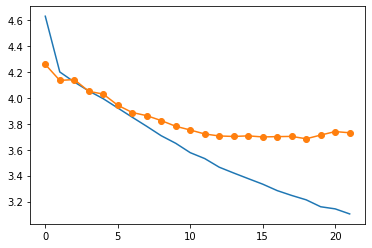

In [ ]:
import matplotlib.pyplot as plt
plt.plot(logger.metrics['training_loss'])
plt.plot(logger.metrics['val_loss'], marker='o')

In [ ]:
for batch_content, batch_title in dataloader_test:
    out_trainer = model(batch_content, batch_title)
    break

In [ ]:
pred_codes = torch.argmax(out_trainer, dim=2)
target_codes = batch_title

rows = []

for idx in range(0,10):
  pred_title = " ".join([token2word[int(token)] for token in pred_codes[idx]])
  target_title = " ".join([token2word[int(token)] for token in target_codes[idx]])
  content = " ".join([token2word[int(token)] for token in batch_content[idx]])

  rows.append([pred_title, target_title, content])


In [ ]:
headers = ["PREDICTED", "TARGET", "ARTICLE"]
display(HTML(tabulate(rows, headers, tablefmt="html")))

PREDICTED,TARGET,ARTICLE
$ kong kong 's new 's of sexual ' $ $ ^ ^ ^ ^,^ hong kong court finds housewife guilty of abusing young maid $ ^ ^ ^,^ hong kong a hong kong housewife has been found guilty of imprisoning and abusing a young indonesian maid whose case has prompted protests and calls for reform of the city 's laws governing domestic workers over several months last year erwiana was kept as a prisoner in the home of law a 44yearold mother of two who regularly deprived her of food sleep and payment for long hours of grueling work after the verdict erwiana thanked her supporters and called for the governments of hong kong and indonesia to do more to protect the rights of migrant workers what i hope together with my fellow domestic workers are just fair and humane treatment and for people to stop treating us like slaves she said law was convicted of grievous bodily harm common assault and failing to pay erwiana 's wages or give her statutory rest days sentencing has been deferred until february 27 to give the defense time to compile character references and psychological reports the ruling $ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^
us korea 's to end to north to us troops korea 's ^ ^ ^,^ north korea ready to go to war with us south korea $ ^ ^,^ seoul north korea said it 's ready to fight a war with the united states and south korea as the two allies kicked off their annual joint military drills monday according to staterun media hundreds of thousands of troops are poised for a war carrying nuclear war equipment north korea 's kcna news agency reported saying pyongyang considers the drills to be practice for a preemptive strike on the north the international community has been negotiating with north korea over its nuclear program for years the most recent talks between north korea and the united states ended friday with little visible progress they were the first highlevel talks since the death of north korea 's longtime leader kim jong il in december and the subsequent transition of power to his youngest son kim jong un kim 's death threw into flux us plans for renewed diplomacy with north korea including formal talks on ending pyongyang 's nuclear program and possible resumption of us food assistance the north korea government was expected to suspend its uranium enrichment in exchange for food assistance as part of a deal that was to be announced around the time of kim 's death $ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^
$ group to syria of us $ $ ^ ^ ^ ^ ^ ^ ^,^ aid workers describe devastation from pakistan floods $ ^ ^ ^ ^ ^ ^,^ the statistics are devastating but for aid workers like faisal kapadia and alvi witnessing the despair from the pakistan flooding was far more tragic than they imagined you can see 8000 to 10000 people in sukkur in the road sleeping in the mud said kapadia a resident of karachi all the people are sitting on the side of road there drinking water there living there roughly 4 million people are homeless from mammoth flooding that covered much of pakistan for three weeks hundreds of health facilities are damaged or destroyed millions are at risk for deadly waterborne diseases from the filthy flood waters officials estimate the death toll between 1500 and 1600 but kapadia says he thinks the numbers could skyrocket as water recedes and more bodies and animals surface everywhere we go we see eight to 10 feet of water said kapadia who traveled through inundated villages between shikarpur and sukkur all we see are the tops of houses $ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^

# Improvements

## Attention

Seq2Seq models often incorporate something known as an ["attention"](https://arxiv.org/abs/1409.0473) mechanism.

An attention mechanism addresses the limitations of the information bottleneck presented by the context vector. We pass the context vector from the encoder to the decoder which generates a hidden state for the first token in the decoder. You multiply the hidden state of the decoder with the hiddne state of each of the hidden states of the input tokens. We apply a softmax to the multiplication between the current time stamp decoder hidden state and all hidden states of the encoder. The output of the softmax becomes weights for each of the corresponding encoder hidden states. 

Finally, it provides the decoder with a weighted sum of the hidden states for each of the encoder time-points and create a new context vector $z_1$ which can be considered as a new hidden state and can be used to generate your vocabulary. 

For each token of the decoder, we are creating a weight for all the encoder tokens. 

Notice that although we have an extra layer, there are no extra weights learned. 

<img src="https://dl.sphericalcow.xyz/ecse552/T7/attention.jpg" width="1000">


This gives us insight on how our model is focusing on different tokens. 

![](https://i.stack.imgur.com/A12Hc.jpg)

## Self-Attention and Transformers

It's also possible to:


1.   Have attention in the encoder which weights an input token by considering the other input tokens (self-attention).
2.   Having multiple attention layers, so that different concepts can be learned (_e.g._ syntax, gender, verb tense)

These concepts, along with the notion of "positional embeddings", are all incorporated in a type of architecture known as a ["Transformer"](https://arxiv.org/abs/1706.03762) which has recently gained much attention (pardon the pun).


<img src="https://davari.io/assets/img/multi-head-attention-example.png" width="600">


<img src="https://davari.io/assets/img/transformer_model_architecture.png" width="400">


Figure from [Reza Davari](https://davari.io/articles/2020-07/attention-is-all-you-read.html) and [(Vaswani et al., January 2017)](https://arxiv.org/abs/1706.03762).



## Beam Search

Seq2Seq, as described here, follows a greedy approach whereby the best candidate is taken at each time-step.

Beam search looks for the best "path" along all the candidates of each time-step to generate the best sentence.

![](https://classic.d2l.ai/_images/beam-search.svg)